## Imports and Boilerplate

In [13]:
from dl2 import dl2lib

import json
import matplotlib.pyplot as plt
import torch

# Basic Model Class
class BasicModel(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BasicModel, self).__init__()

        assert len(hidden_sizes) >= 1

        # Create hidden layers dynamically using a loop
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                # First hidden layer connected to the input
                layers.append(torch.nn.Linear(input_size, hidden_sizes[i]))
            else:
                # Subsequent hidden layers connected to the previous hidden layer
                layers.append(torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

            layers.append(torch.nn.ReLU())

        # Output layer
        layers.append(torch.nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size))

        # Combine all layers into a sequential module
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, inp):
        return self.layers(inp)

# Model class that works on intervals
class IntervalNN(BasicModel):
    def __init__(self, num_interval_inputs, hidden_sizes, output_size):
        super().__init__(2*num_interval_inputs, hidden_sizes, output_size)

    def forward(self, *intervs):
        if len(intervs) == 1:
            inp = intervs[0]
        else:
            inp = torch.cat(tuple(intervs), dim = 1)

        return super().forward(inp)

## Loading the data

In [14]:
def load_data(file_name):
    with open(file_name, "r") as f:
        obj = json.load(f)

    intervs = []
    abs_ints = []

    for o in obj:
        intervs.append(torch.tensor(o["interv"]))
        abs_ints.append(torch.tensor(o["abs"]))


    intervs = torch.stack(intervs, dim = 0)
    abs_ints = torch.stack(abs_ints, dim = 0)

    return intervs, abs_ints

intervs, abs_ints = load_data("datasets/interv_abs_train_data.json")

## Unsupervised training for sound learning of Interval Abs

0.0


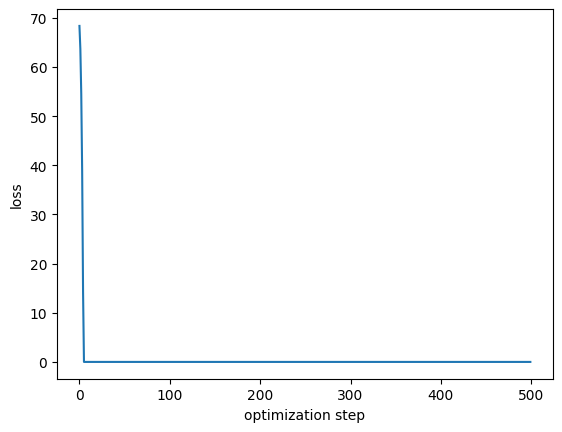

In [15]:
from dl2.dl2lib import diffsat

def train_sound_abs_model(model, opt, epochs, intervs, abs_ints):
    loss_history = []

    for _ in range(epochs):
        opt.zero_grad()
        outp = model(intervs)

        # Write the logical constraint for soundness here using the DL library
        # constrain
        # (pred_l <= min(|l|, |u|)) AND (pred_l <= min(|l|, |u|))

        pred_l, pred_u = outp[:, 0], outp[:, 1]

        constrains = []
        # (pred_l <= min(|l|, |u|))
        constrains.append(diffsat.LEQ(pred_l, torch.min(torch.abs(intervs), dim=1)[0]))
        # (pred_l <= min(|l|, |u|))
        constrains.append(diffsat.GEQ(pred_u, torch.max(torch.abs(intervs), dim=1)[0]))

        soundness_loss = diffsat.And(constrains).loss(None).mean()


        loss_history.append(soundness_loss.item())
        soundness_loss.backward()
        opt.step()

    return loss_history

sound_abs_model = IntervalNN(1,[8,16,8],2)
lr = 0.04
epochs = 500
opt = torch.optim.Adam(sound_abs_model.parameters(), lr)
loss_history = train_sound_abs_model(sound_abs_model, opt, epochs, intervs, abs_ints)
print(loss_history[-1])

plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss')
plt.show()

## Evaluate model's quality

After training our model, we check its quality by measuring 2 metrics:
1. Soundness: We use our model to find the absolute of the intervals in a test set and then check if the returned absolute interval is sound. As we have the ground truths in the test set, this is easy to check; the ground truth abs interval should be inside the predicted interval.
2. Imprecision: For the cases where the predicted answer is sound, we also measure how big the predicted interval is as compared to the ground truth.

Ideally, we want a model that is very sound and as precise it can be, i.e. one with **high soundness and low imprecision**.

In [16]:
def evaluate_model(model):
    # load data from test file
    intervs, abs_ints = load_data("datasets/interv_abs_test_data.json")

    # get output from the model
    output = model(intervs)

    # Measuring soundness!
    ctr = 0
    unsound_ctr = 0

    # Difference in the ranges of intervals (only count in cases of sound answers)
    precision_sum = 0

    for into, intg in zip(output, abs_ints):
        ctr += 1

        if (into[0] > intg[0]) or (into[1] < intg[1]):
            unsound_ctr += 1
        else:
            # If sound, measure precision
            precision_sum += ((into[1]-into[0]) - (intg[1] - intg[0])).item()


    print("Soundness Measure:" , ((ctr-unsound_ctr)/ctr)*100, " ({} out of {})".format(ctr-unsound_ctr, ctr))

    if ctr != unsound_ctr:
        print("Imprecision Measure:" , (precision_sum/(ctr-unsound_ctr)), " ({} diff. in {} cases)".format(precision_sum, ctr-unsound_ctr))
    else:
        print("Imprecision Measure: -")

    return (ctr-unsound_ctr)/ctr, precision_sum/(ctr-unsound_ctr)

evaluate_model(sound_abs_model)

Soundness Measure: 100.0  (5000 out of 5000)
Imprecision Measure: 2591.563416505432  (12957817.08252716 diff. in 5000 cases)


(1.0, 2591.563416505432)

If the soundness loss is implemented correctly, then we will observe a very high soundness accuracy of the model. But observe that the imprecision measure is also very high. This is expected because in our loss method, we only optimized for soundness. This made the model learn very large intervals like say (0, 1000), when the ground truth abs is (1, 80). We will now handle this by also including a precision penalty in the loss method, which should incentivize the model to learn smaller intervals.

## Supervised training for sound *and precise* learning of Interval Abs

Add a precision loss to the training. The combined loss is a weighted combination of the soundness and precision losses. We set the weights 20:1 for now.

26.455888748168945


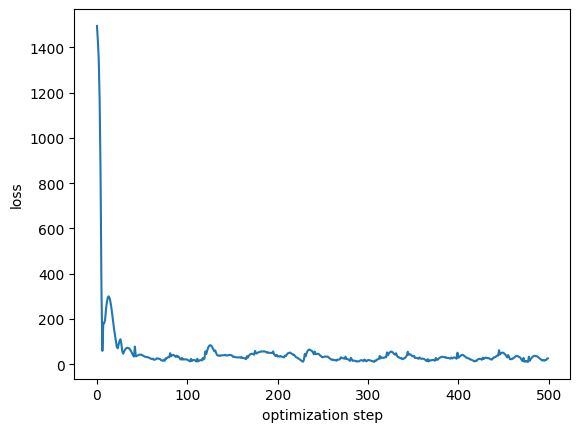

In [17]:
def train_sound_and_prec_abs_model(model, opt, epochs, intervs, abs_intervs, soundness_weight, precision_weight):
    loss_history = []

    for _ in range(epochs):
        opt.zero_grad()
        outp = model(intervs)

        pred_l, pred_u = outp[:, 0], outp[:, 1]
        true_l, true_u = abs_ints[:, 0], abs_ints[:, 1]

        # Write the same soundness loss as before here
        constrains = []
        # pred_l <= true_l
        constrains.append(diffsat.LEQ(pred_l, true_l))
        # (pred_u >= true_u)
        constrains.append(diffsat.GEQ(pred_u, true_u))

        soundness_loss = diffsat.And(constrains).loss(None).mean()
        # Write the precision loss here
        precision_loss = torch.abs(pred_l - true_l).mean() + torch.abs(pred_u - true_u).mean()

        loss = soundness_weight * soundness_loss + precision_weight * precision_loss
        loss_history.append(loss.item())
        loss.backward()
        opt.step()

    return loss_history

sound_and_prec_abs_model = IntervalNN(1,[8,16,8],2)
lr = 0.04
epochs = 500
opt = torch.optim.Adam(sound_and_prec_abs_model.parameters(), lr)
sw = 20
pw = 1
loss_history = train_sound_and_prec_abs_model(sound_and_prec_abs_model, opt, epochs, intervs, abs_ints, sw, pw)
print(loss_history[-1])

plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss');
plt.show()

In [18]:
evaluate_model(sound_and_prec_abs_model)

Soundness Measure: 92.56  (4628 out of 5000)
Imprecision Measure: 32.4421156124504  (150142.11105442047 diff. in 4628 cases)


(0.9256, 32.4421156124504)

## Studying Soundness vs Precision Tradeoff

Analyze the soundness/precision tradeoff by experimenting with different ratios, 20:1, 10:1, etc. Plot the results and report your observations.

11.635900497436523


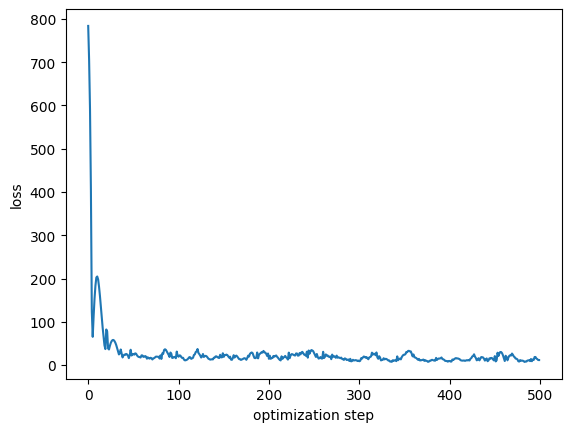

Soundness Measure: 75.22  (3761 out of 5000)
Imprecision Measure: 8.601587602256048  (32350.570972085 diff. in 3761 cases)


In [9]:
# sw : pw = 10 : 1
sound_and_prec_abs_model = IntervalNN(1,[8,16,8],2)
lr = 0.04
epochs = 500
opt = torch.optim.Adam(sound_and_prec_abs_model.parameters(), lr)
sw = 10
pw = 1
loss_history = train_sound_and_prec_abs_model(sound_and_prec_abs_model, opt, epochs, intervs, abs_ints, sw, pw)
print(loss_history[-1])

plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss')
plt.show()

evaluate_model(sound_and_prec_abs_model)

7.721802711486816


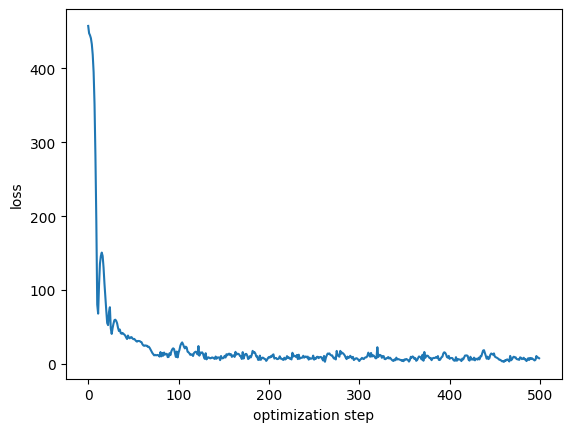

Soundness Measure: 71.34  (3567 out of 5000)
Imprecision Measure: 3.6784779713673186  (13121.130923867226 diff. in 3567 cases)


In [10]:
# sw : pw = 5 : 1
sound_and_prec_abs_model = IntervalNN(1,[8,16,8],2)
lr = 0.04
epochs = 500
opt = torch.optim.Adam(sound_and_prec_abs_model.parameters(), lr)
sw = 5
pw = 1
loss_history = train_sound_and_prec_abs_model(sound_and_prec_abs_model, opt, epochs, intervs, abs_ints, sw, pw)
print(loss_history[-1])

plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss')
plt.show()

evaluate_model(sound_and_prec_abs_model)

51.361568450927734


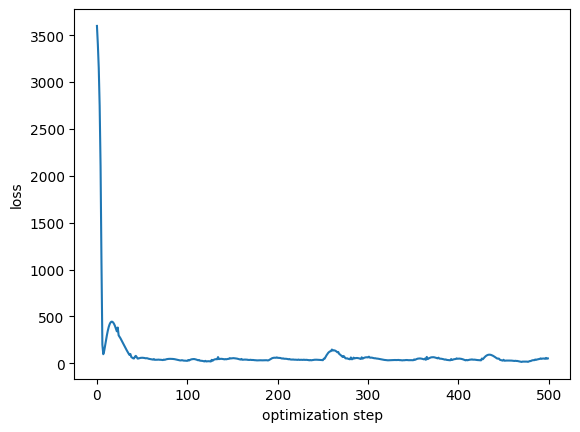

Soundness Measure: 100.0  (5000 out of 5000)
Imprecision Measure: 52.40347991614342  (262017.3995807171 diff. in 5000 cases)


In [11]:
# sw : pw = 50 : 1
sound_and_prec_abs_model = IntervalNN(1,[8,16,8],2)
lr = 0.04
epochs = 500
opt = torch.optim.Adam(sound_and_prec_abs_model.parameters(), lr)
sw = 50
pw = 1
loss_history = train_sound_and_prec_abs_model(sound_and_prec_abs_model, opt, epochs, intervs, abs_ints, sw, pw)
print(loss_history[-1])

plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss')
plt.show()

evaluate_model(sound_and_prec_abs_model)

79.17408752441406


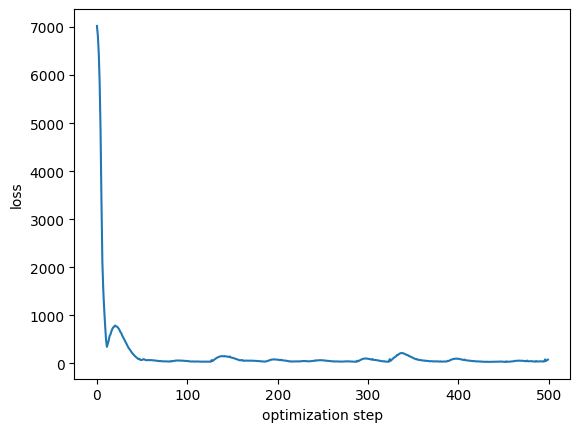

Soundness Measure: 100.0  (5000 out of 5000)
Imprecision Measure: 89.88338466396331  (449416.9233198166 diff. in 5000 cases)


In [12]:
# sw : pw = 100 : 1
sound_and_prec_abs_model = IntervalNN(1,[8,16,8],2)
lr = 0.04
epochs = 500
opt = torch.optim.Adam(sound_and_prec_abs_model.parameters(), lr)
sw = 100
pw = 1
loss_history = train_sound_and_prec_abs_model(sound_and_prec_abs_model, opt, epochs, intervs, abs_ints, sw, pw)
print(loss_history[-1])

plt.plot(loss_history)
plt.xlabel('optimization step')
plt.ylabel('loss')
plt.show()

evaluate_model(sound_and_prec_abs_model)

In [25]:
# plot all
sound_all = []
precision_all = []
sws = [0, 5, 10, 20, 40, 50, 100, 200]

for sw in sws:
    sound_and_prec_abs_model = IntervalNN(1,[8,16,8],2)
    lr = 0.04
    epochs = 500
    opt = torch.optim.Adam(sound_and_prec_abs_model.parameters(), lr)
    pw = 1
    loss_history = train_sound_and_prec_abs_model(sound_and_prec_abs_model, opt, epochs, intervs, abs_ints, sw, pw)
    sound, precision = evaluate_model(sound_and_prec_abs_model)
    sound_all.append(sound)
    precision_all.append(precision)

Soundness Measure: 1.24  (62 out of 5000)
Imprecision Measure: 2.4170651608897793  (149.85803997516632 diff. in 62 cases)
Soundness Measure: 62.62  (3131 out of 5000)
Imprecision Measure: 7.950615894790657  (24893.378366589546 diff. in 3131 cases)
Soundness Measure: 82.42  (4121 out of 5000)
Imprecision Measure: 13.553059292747916  (55852.15734541416 diff. in 4121 cases)
Soundness Measure: 73.74000000000001  (3687 out of 5000)
Imprecision Measure: 13.968300283423988  (51501.123144984245 diff. in 3687 cases)
Soundness Measure: 100.0  (5000 out of 5000)
Imprecision Measure: 46.97632042279243  (234881.60211396217 diff. in 5000 cases)
Soundness Measure: 94.56  (4728 out of 5000)
Imprecision Measure: 51.30648696084717  (242577.0703508854 diff. in 4728 cases)
Soundness Measure: 100.0  (5000 out of 5000)
Imprecision Measure: 147.69643513298035  (738482.1756649017 diff. in 5000 cases)
Soundness Measure: 98.18  (4909 out of 5000)
Imprecision Measure: 195.94383502555345  (961888.2861404419 diff.

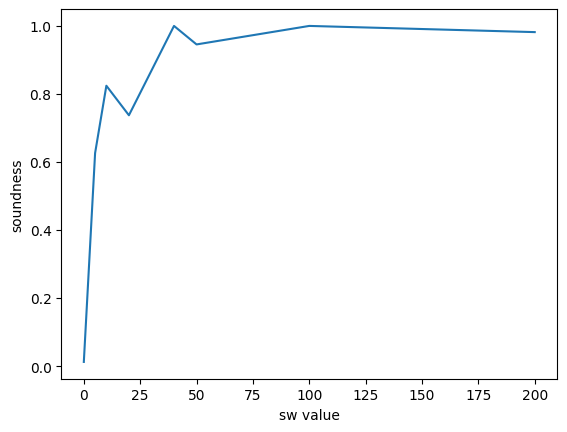

In [26]:
plt.plot(sws, sound_all)
plt.xlabel('sw value')
plt.ylabel('soundness')
plt.show()

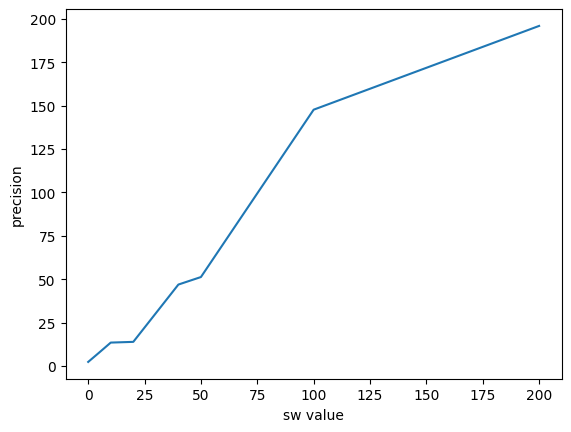

In [27]:
plt.plot(sws, precision_all)
plt.xlabel('sw value')
plt.ylabel('precision')
plt.show()